In [8]:
import tensorflow as tf
from tqdm import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

# Scikit-learn includes many helpful utilities

import re
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd
import string
import re
from tokenizers import SentencePieceBPETokenizer

#from models import CNN_Encoder, RNN_Decoder, image_features_extract_model

In [9]:
def clean(cap):
    return re.sub('\s+',' ',cap.translate(str.maketrans('', '', string.punctuation)))

In [10]:
data = pd.read_csv('train.csv')
print(data.shape)
data.tail(2)

(32000, 6)


,Unnamed: 0,Unnamed: 0.1,captions,paths,sent_len,title
31998,31998,30985,what to do if you see something you disagree w...,./disney_img/42547.jpg,12.0,what to do if you see something you disagree w...
31999,31999,18258,how to drink jägermeister,./disney_img/25390.jpg,4.0,how to drink jägermeister


In [4]:
# data.captions = data.title.apply(clean)
#### data.to_csv('train.csv')

In [11]:
data['captions'] =  data['captions'].astype(str)
data['sent_len'] = data['captions'].apply(lambda r: len(r.split(' ')))
data = data[(data['sent_len']<20) & (data['sent_len']>4)]
data.hist('sent_len')

In [13]:
images = data.paths.to_list()
captions = data.captions.to_list()

with open('titles.txt', 'w') as f:
    for t in captions:
        f.write(t+'\n')

In [14]:
# Feel free to change these parameters according to your system's configuration

VOCAB_SIZE = 5000
BATCH_SIZE = 32
BUFFER_SIZE = 1000  # for shuffle 
embedding_dim = 512 # should not be equal units
embedding_words = 300
units = 512 # gru param
embedding_size = VOCAB_SIZE + 1
num_steps = len(images) // BATCH_SIZE
MAX_LENGTH = 20

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
# features_shape = 2048a
# attention_features_shape = 64

# features_shape_two = 768
# attention_features_two_shape = 17*17

CHECKPOINT_FOLDER = "./checkpoint_dis/bpe_tokenizer"
TOKENIZER_FOLDER = './tokenizer/'

In [23]:
def make_tokenizer(text_lines, 
                   folder=TOKENIZER_FOLDER, 
                   file_name='spbe_tokenizer.e',
                   text_file_name='titles.txt'):
    
    with open(text_file_name, 'w') as f:
        for t in text_lines:
            f.write(t+'\n')
            
    sbpe_tokenizer = SentencePieceBPETokenizer()
    sbpe_tokenizer.train(files='titles.txt', vocab_size=VOCAB_SIZE-2)
    sbpe_tokenizer.enable_padding(max_length=MAX_LENGTH)
    sbpe_tokenizer.add_special_tokens(['<start>','<end>'])
    sbpe_tokenizer.save(TOKENIZER_FOLDER,file_name)
    return sbpe_tokenizer

sbpe_tokenizer=make_tokenizer(captions)

In [24]:
sbpe_tokenizer.id_to_token(777)

'▁shit'

In [2]:
def load_image_aug(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 10)
        if bool(np.random.randint(2)):
            img = img +  tf.keras.backend.random_normal((299,299,3),0,np.random.randint(20))
        if bool(np.random.randint(2)):
            img = tf.image.random_contrast(img, 0, 2)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, image_path

In [28]:
def make_dataset(images, captions, loader=load_image_aug, max_len=MAX_LENGTH):
    
    out = sbpe_tokenizer.encode_batch(['<start> '+t+' <end>'  for t in captions])
    encoded_list= [t.ids for t in out]

    captions_filtered = []
    images_filtered = []

    for i,t in enumerate(encoded_list):
        if len(t)<=max_len:
            captions_filtered.append(t)
            images_filtered.append(images[i])

    images = images_filtered
    
    print('max title len',max(len(t) for t in captions_filtered))
    print(f'len titles: {len(captions_filtered)},len images: {len(images)}')
    encoded_captios =  tf.convert_to_tensor(captions_filtered)
    print(f'captions vector shape {encoded_captios.shape}')
    
    # Load the numpy files
    def map_func(img_name, cap):
        #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
        img_tensor = loader(img_name)
        return img_tensor, cap

    dataset = tf.data.Dataset.from_tensor_slices((images, encoded_captios))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(map_func)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset, encoded_captios


In [ ]:
dataset, encoded_captios = make_dataset(images, captions)

In [17]:
encoded_captios[0]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([4998,  151,  149,  450,  276, 1194, 4676,  417, 3175,  115, 4999,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)>

yoga poses for reddit karma 
[['▁yoga', '▁pos', 'es', '▁for', '▁reddit', '▁karma', '▁', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']]


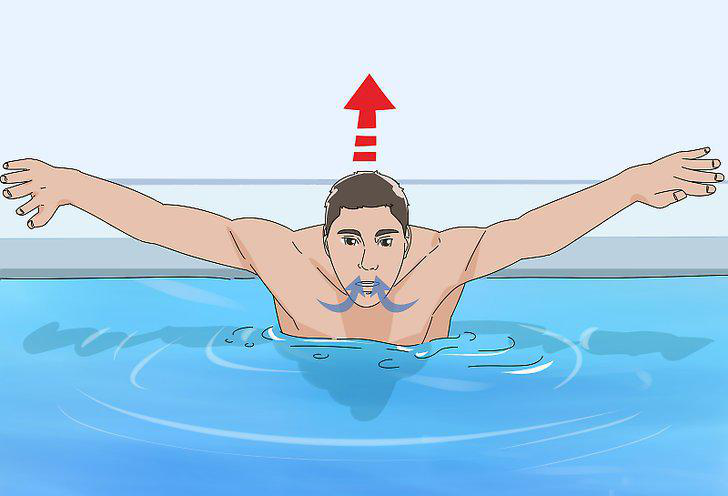

In [18]:
n = np.random.randint(len(encoded_captios))
string = sbpe_tokenizer.decode(encoded_captios[n])
print(string)
print([sbpe_tokenizer.encode(string).tokens])
Image.open(images[n])

In [16]:
# words = [w.lower() for s in disney_captions for w in s.split(' ')]
# print(f' vocab size: {len(set(words))}')
# print(f' captions size: {len(disney_captions) }')
# print(f' min len for captions {min(len(t.split(" ")) for t in disney_captions)}')
# print(f' max len for captions {max(len(t.split(" ")) for t in disney_captions)}')

In [19]:
encoder= CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_words, units, embedding_size)

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):  # ZERO PADS <pad> idx - 0 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)   

In [21]:
checkpoint_path = CHECKPOINT_FOLDER
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                          optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [26]:
## LOAD LAST CHECK POINT

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(f'load from {ckpt_manager.latest_checkpoint}')
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

load from ./checkpoint_dis/bpe_tokenizer/ckpt-9


In [290]:
# preds = np.random.normal(size=(1,3001))
# loss_function(1, preds)

# real = np.array([1,1,23,11,3,21])

# mask = tf.math.logical_not(tf.math.equal(real, 0))
# loss_ = loss_object(real, preds)

# mask = tf.cast(mask, dtype=loss_.dtype)
# loss_ *= mask

# tf.reduce_mean(loss_)

In [27]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(image_array, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([sbpe_tokenizer.token_to_id('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        ### CNN Encoder
        batch_features_one, batch_features_two  = image_features_extract_model(image_array)
        # 768               2048
        
        # reshape ex. from  [32, 8, 8, 2048] to [32, 64, 2048]
        batch_features_one = tf.reshape(batch_features_one,
                                    (batch_features_one.shape[0], -1, batch_features_one.shape[3]))  
        
        batch_features_two = tf.reshape(batch_features_two,
                                    (batch_features_two.shape[0], -1, batch_features_two.shape[3]))
        
        features_one, features_two = encoder(batch_features_one, batch_features_two)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [ ]:
# SAVE EACH K EPOCHS

K = 5

EPOCHS = 60

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (image_array, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(image_array, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % K == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 10 Batch 0 Loss 1.3066
Epoch 10 Batch 100 Loss 0.5115
Epoch 10 Batch 200 Loss 0.5059
Epoch 10 Batch 300 Loss 0.6367
Epoch 10 Batch 400 Loss 0.7405
Epoch 10 Batch 500 Loss 0.8285
Epoch 10 Batch 600 Loss 0.7302
Epoch 10 Batch 700 Loss 0.8752
Epoch 10 Batch 800 Loss 0.7897
Epoch 10 Batch 900 Loss 0.7542
Epoch 10 Loss 0.711539
Time taken for 1 epoch 137.16801810264587 sec

Epoch 11 Batch 0 Loss 0.5960
Epoch 11 Batch 100 Loss 0.4135
Epoch 11 Batch 200 Loss 0.5632
Epoch 11 Batch 300 Loss 0.4864
Epoch 11 Batch 400 Loss 0.7379
Epoch 11 Batch 500 Loss 0.5577
Epoch 11 Batch 600 Loss 0.5865
Epoch 11 Batch 700 Loss 0.4642
Epoch 11 Batch 800 Loss 0.6144
Epoch 11 Batch 900 Loss 0.6206
Epoch 11 Loss 0.563021
Time taken for 1 epoch 122.56170606613159 sec

Epoch 12 Batch 0 Loss 0.6198
Epoch 12 Batch 100 Loss 0.4419
Epoch 12 Batch 200 Loss 0.6020
Epoch 12 Batch 300 Loss 0.4443
Epoch 12 Batch 400 Loss 0.5044
Epoch 12 Batch 500 Loss 0.4002
Epoch 12 Batch 600 Loss 0.4380
Epoch 12 Batch 700 Loss 0.476

In [39]:
!rm -rf ~/.nv